In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import ComplementNB
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.stem.porter import PorterStemmer


In [2]:
con = sqlite3.connect('./database.sqlite') 

In [3]:
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

In [4]:
def partition(x):
    if x < 3:
        return 0
    return 1

In [5]:
#changing the score to +ve or -ve
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [6]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#droping any duplicates that could exist 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [9]:
score=final["Score"]
print(final.shape)
print("#####################")
final['Score'].value_counts()

(364171, 10)
#####################


1    307061
0     57110
Name: Score, dtype: int64

In [10]:
import nltk
nltk.download('stopwords')
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to /home/rahul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string
final['CleanedSummary']=final_sum_string

In [14]:
x_train=final["CleanedText"][:254919][:]
x_test=final["CleanedText"][254919:][:]
y_train=score[:254919]
y_test=score[254919:]

In [21]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(254919,)
(254919,)
(109252,)
(109252,)


# Bow

In [22]:
count_vec = CountVectorizer() 
final_counts_train = count_vec.fit_transform(x_train.values)
final_counts_test = count_vec.transform(x_test.values)

In [23]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
alpha={'alpha':np.arange(0.0001,10,0.01)} 
my_cv = TimeSeriesSplit(n_splits=10)

###### Using ComplementNB as it is particularly suited for imbalanced data sets.

In [24]:
grid = GridSearchCV(ComplementNB(), alpha, cv=my_cv, scoring='f1',n_jobs=-1)

In [84]:
%time grid.fit(final_counts_train,y_train)


CPU times: user 1min 23s, sys: 32.2 s, total: 1min 56s
Wall time: 29min 50s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([1.0000e-04, 1.0100e-02, ..., 9.9801e+00, 9.9901e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

/home/rahul/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


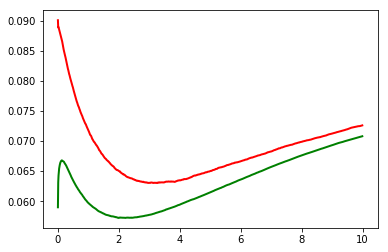

In [85]:
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]
lines = plt.plot(alpha["alpha"],Mis_clas_error, alpha["alpha"],train_error )
plt.setp(lines[0], color='r', linewidth=2.0, label="misclassification error")
plt.setp(lines[1], color='g', linewidth=2.0,label="train error")
plt.show()

Accuracy for {'alpha': 3.2601000000000004}
89.48211474389484
[[12396  5962]
 [ 5529 85365]]


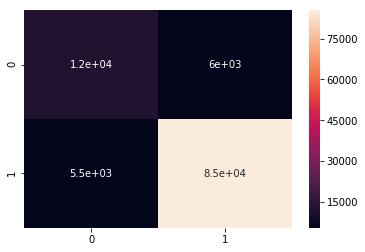

In [29]:
from sklearn.metrics import accuracy_score
optimal_k=grid.best_params_ 
pre=grid.predict(final_counts_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True)
print(conf_matr)

In [30]:
print("precision score = ",sklearn.metrics.precision_score(y_test,pre))
print("recall score = ",sklearn.metrics.recall_score(y_test,pre))
print("f1_score = ",sklearn.metrics.f1_score(y_test,pre))


precision score =  0.9347181008902077
recall score =  0.9391709023697934
f1_score =  0.9369392111776359


In [45]:
cnb=ComplementNB(alpha = optimal_k["alpha"])
cnb.fit(final_counts_train,y_train)
pre=cnb.predict(final_counts_test)
#feature importance
sorted_pos_features = cnb.feature_log_prob_[0, :].argsort()
sorted_neg_features = cnb.feature_log_prob_[1, :].argsort()
print("top 100 important positive features are:\n")
print(np.take(count_vec.get_feature_names(), sorted_pos_features [:101]))
print("\ntop 100 important negative features are:\n")
print(np.take(count_vec.get_feature_names(), sorted_neg_features [:101]))

top 100 important positive features are:

['like' 'tast' 'good' 'love' 'use' 'great' 'flavor' 'one' 'tea' 'product'
 'tri' 'make' 'get' 'coffe' 'food' 'time' 'buy' 'amazon' 'eat' 'would'
 'find' 'realli' 'price' 'best' 'also' 'order' 'much' 'dont' 'dog' 'store'
 'littl' 'well' 'ive' 'bag' 'even' 'drink' 'mix' 'year' 'better' 'day'
 'recommend' 'chocol' 'found' 'sugar' 'box' 'high' 'sweet' 'treat' 'brand'
 'first' 'give' 'want' 'look' 'work' 'enjoy' 'delici' 'add' 'cup' 'cat'
 'purchas' 'water' 'need' 'way' 'favorit' 'made' 'packag' 'nice' 'sinc'
 'bought' 'think' 'keep' 'perfect' 'bit' 'two' 'thing' 'lot' 'mani'
 'differ' 'know' 'milk' 'come' 'pack' 'say' 'hot' 'free' 'fresh' 'everi'
 'take' 'alway' 'snack' 'still' 'ship' 'could' 'cant' 'local' 'sauc'
 'wonder' 'stuff' 'review' 'never' 'without']

top 100 important negative features are:

['tast' 'like' 'product' 'one' 'flavor' 'would' 'tri' 'use' 'good' 'food'
 'buy' 'get' 'order' 'tea' 'coffe' 'dont' 'even' 'box' 'amazon' 'bag'
 'eat

## Positive class Word cloud 

(-0.5, 399.5, 199.5, -0.5)

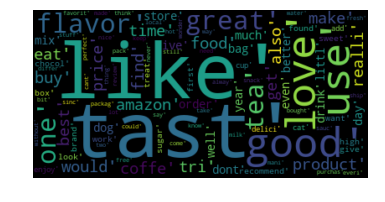

In [37]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(list((np.take(count_vec.get_feature_names(), sorted_pos_features [:101])))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Negative class Word cloud 

(-0.5, 399.5, 199.5, -0.5)

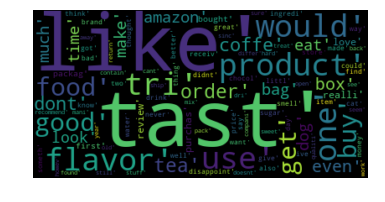

In [38]:
wordcloud = WordCloud().generate(str(list((np.take(count_vec.get_feature_names(), sorted_neg_features [:101])))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")                                 

# TFIDF

In [46]:
tfidf_vec=TfidfVectorizer()
final_tfidf_train=tfidf_vec.fit_transform(x_train.values)
final_tfidf_test=tfidf_vec.transform(x_test.values)

###### Using ComplementNB as it is particularly suited for imbalanced data sets.

In [58]:
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 1min 21s, sys: 31 s, total: 1min 52s
Wall time: 25min 28s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': array([1.0000e-04, 1.0100e-02, ..., 9.9801e+00, 9.9901e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

/home/rahul/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Accuracy for {'alpha': 0.7901}
89.02994910848314
[[11398  6960]
 [ 5025 85869]]


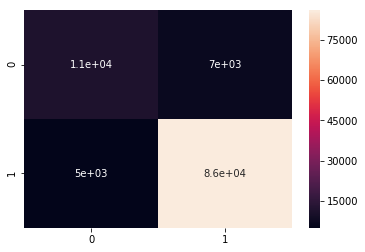

In [65]:
from sklearn.metrics import accuracy_score
optimal_k=grid.best_params_ 
cv_scores=grid.cv_results_ ['mean_test_score']
train_scores=grid.cv_results_ ['mean_train_score']
pre=grid.predict(final_tfidf_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for",optimal_k)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True)
print(conf_matr)

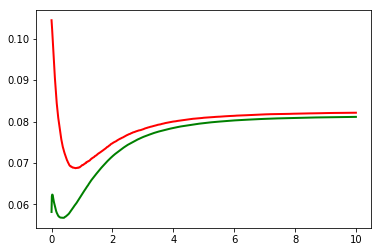

In [83]:
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]
lines = plt.plot(alpha["alpha"],Mis_clas_error, alpha["alpha"],train_error )
plt.setp(lines[0], color='r', linewidth=2.0, label="misclassification error")
plt.setp(lines[1], color='g', linewidth=2.0,label="train error")
plt.show()


In [67]:
print("precision score = ",sklearn.metrics.precision_score(y_test,pre))
print("recall score = ",sklearn.metrics.recall_score(y_test,pre))
print("f1_score = ",sklearn.metrics.f1_score(y_test,pre))


precision score =  0.9250234301780693
recall score =  0.9447158228265892
f1_score =  0.9347659247889485


In [68]:
cnb=ComplementNB(alpha = optimal_k["alpha"])
cnb.fit(final_tfidf_train,y_train)
pre=cnb.predict(final_tfidf_test)
#feature importance
sorted_pos_features = cnb.feature_log_prob_[0, :].argsort()
sorted_neg_features = cnb.feature_log_prob_[1, :].argsort()
print("top 100 important positive features are:\n")
print(np.take(tfidf_vec.get_feature_names(), sorted_pos_features [:101]))
print("\ntop 100 important negative features are:\n")
print(np.take(tfidf_vec.get_feature_names(), sorted_neg_features [:101]))

top 100 important positive features are:

['great' 'love' 'tea' 'good' 'tast' 'like' 'flavor' 'product' 'use'
 'coffe' 'one' 'tri' 'make' 'get' 'price' 'food' 'best' 'buy' 'amazon'
 'find' 'order' 'time' 'dog' 'eat' 'realli' 'store' 'would' 'much' 'littl'
 'well' 'bag' 'drink' 'also' 'ive' 'dont' 'mix' 'chocol' 'better'
 'recommend' 'treat' 'year' 'delici' 'day' 'even' 'favorit' 'sweet' 'high'
 'enjoy' 'found' 'sugar' 'purchas' 'box' 'snack' 'nice' 'brand' 'cat'
 'perfect' 'work' 'cup' 'bought' 'give' 'ship' 'add' 'packag' 'look'
 'need' 'easi' 'keep' 'want' 'wonder' 'fresh' 'free' 'cant' 'local' 'way'
 'first' 'alway' 'hot' 'lot' 'pack' 'excel' 'everi' 'ever' 'stuff' 'milk'
 'made' 'bar' 'mani' 'sinc' 'bit' 'water' 'sauc' 'think' 'healthi' 'thing'
 'quick' 'thank' 'differ' 'come' 'qualiti' 'right']

top 100 important negative features are:

['tast' 'product' 'like' 'would' 'one' 'flavor' 'buy' 'order' 'tri'
 'coffe' 'tea' 'box' 'disappoint' 'good' 'dont' 'food' 'use' 'get' 'bag'
 'eve

## Positive class Word cloud

(-0.5, 399.5, 199.5, -0.5)

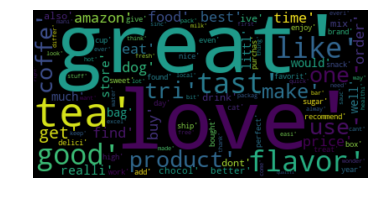

In [69]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(list((np.take(tfidf_vec.get_feature_names(), sorted_pos_features [:101])))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

## Negative class Word cloud

(-0.5, 399.5, 199.5, -0.5)

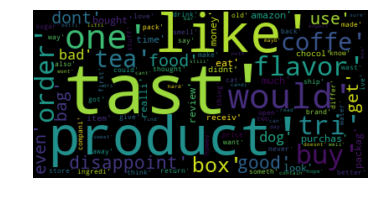

In [70]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(str(list((np.take(tfidf_vec.get_feature_names(), sorted_neg_features [:101])))))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Observation

In [80]:
from prettytable import PrettyTable
table= PrettyTable()
table.field_names = ["Vectorizer","Model","hyperparameter","Accuracy","precision score","f1 score","recall score"]
table.add_row(["Bow","ComplementNB",3.26010,89.4821,0.9347,0.9369, 0.9391])
table.add_row(["Tfidf","ComplementNB",0.7901,89.0299,0.9250,0.9347, 0.9447])

In [81]:
print(table)

+------------+--------------+----------------+----------+-----------------+----------+--------------+
| Vectorizer |    Model     | hyperparameter | Accuracy | precision score | f1 score | recall score |
+------------+--------------+----------------+----------+-----------------+----------+--------------+
|    Bow     | ComplementNB |     3.2601     | 89.4821  |      0.9347     |  0.9369  |    0.9391    |
|   Tfidf    | ComplementNB |     0.7901     | 89.0299  |      0.925      |  0.9347  |    0.9447    |
+------------+--------------+----------------+----------+-----------------+----------+--------------+
